In [25]:
import torch
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

In [26]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [28]:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [29]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)

In [30]:
def build_NN():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48*48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [31]:
from tqdm import tqdm

In [32]:
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history

In [33]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [34]:
net = build_NN()

In [35]:
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 20.97, Acc: 1.00: 100%|██████████| 1500/1500 [00:06<00:00, 223.04it/s]


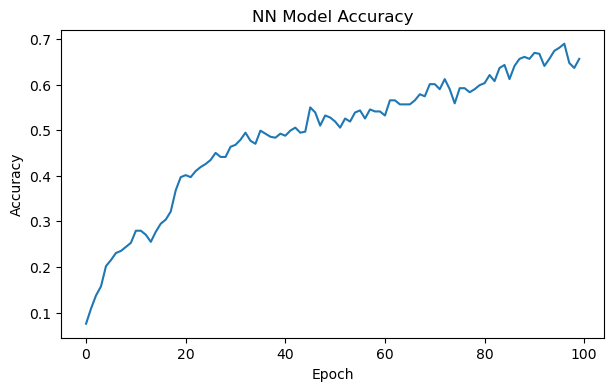

In [36]:
print_history(hist, "NN Model Accuracy")